# Data ETL for analysis

## Overview
- Read compressed CSV files
- Remove bad quality data
- Resample data
- Save raw and resampled data to DB

In [2]:
# import libraries
import os
import math
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns

# config for graphs
%matplotlib inline
sns.set(rc={"figure.figsize": (26, 10)})

# Sensor descriptions

A description of the various sensors are located in the `sensors_sensor_202107282041.csv`. It includes:
- `sensor_id` to match with the daily data files.
- `sensor_type` and `sensor_uom` (unit of measure).
- `sensor_ucl` and `sensor_lcl` which are the upper and lower control limits used for alerts.
- `sensor_uucl` and `sensor_llcl` which are the upper upper and lower lower control limits used for alarms.

In [3]:
# get sensor meta data
df_meta = pd.read_csv("../data/sensors_sensor_202107282041.csv", parse_dates=True, index_col="sensor_id")
df_meta.head(15)

,sensor_name,sensor_description,sensor_type,sensor_ucl,sensor_lcl,sensor_created_date,sensor_modified_date,sensor_state,sensor_llcl,sensor_uucl,...,sensor_critical_active,sensor_uom,sensor_lspec,sensor_uspec,sensor_report_id,sensor_register,device_name_id,sensor_order_id,sensor_tolerance,sensor_show_matrix
sensor_id,,,,,,,,,,,,,,,,,,,,,
24,New cold room temperature [2],NaN,Temperature,NaN,NaN,2021-03-27 21:06:43.574897000,2021-03-28 11:17:00.330146000,active,NaN,NaN,...,0,°C,NaN,NaN,1,3,9,1,5.0,1
25,WIP temperature probe,NaN,Temperature,NaN,NaN,2021-03-28 11:18:28.285837000,2021-04-21 09:52:36.092212000,active,NaN,NaN,...,0,°C,NaN,NaN,1,1,9,2,10.0,1
26,WIP cold room temperature [2],NaN,Temperature,NaN,NaN,2021-03-28 11:19:22.187758000,2021-04-21 09:52:18.396540000,active,NaN,NaN,...,0,°C,NaN,NaN,1,2,9,3,10.0,1
27,High-risk prep temperature,NaN,Temperature,NaN,NaN,2021-03-28 11:20:35.748534000,2021-03-28 11:20:35.748680000,active,NaN,NaN,...,0,°C,NaN,NaN,1,1,10,4,5.0,1
28,Low-risk prep temperature,NaN,Temperature,NaN,NaN,2021-03-28 11:21:13.365155000,2021-03-28 11:21:13.365253000,active,NaN,NaN,...,0,°C,NaN,NaN,1,2,10,5,5.0,1
29,WIP cold room temperature [1],NaN,Temperature,8.5,0.0,2021-03-28 11:21:42.891440000,2021-03-30 10:30:42.631335000,active,-2.0,10.0,...,1,°C,0.0,5.0,1,3,10,6,5.0,1
30,Dispatch cold room temperature,NaN,Temperature,8.5,0.0,2021-03-28 11:22:12.671387000,2021-04-21 09:52:51.067454000,active,-2.0,10.0,...,1,°C,0.0,5.0,1,4,10,7,10.0,1
31,External temperature,NaN,Temperature,NaN,NaN,2021-03-28 11:22:35.509809000,2021-03-28 11:22:35.509904000,active,NaN,NaN,...,0,°C,NaN,NaN,1,5,10,8,5.0,1
32,New cold room temperature [2],NaN,Temperature,NaN,NaN,2021-03-28 11:23:06.673252000,2021-03-28 11:23:06.673420000,active,NaN,NaN,...,0,°C,NaN,NaN,1,6,10,9,5.0,1


In [4]:
df_meta.columns

Index(['sensor_name', 'sensor_description', 'sensor_type', 'sensor_ucl',
       'sensor_lcl', 'sensor_created_date', 'sensor_modified_date',
       'sensor_state', 'sensor_llcl', 'sensor_uucl', 'sensor_alert_active',
       'sensor_critical_active', 'sensor_uom', 'sensor_lspec', 'sensor_uspec',
       'sensor_report_id', 'sensor_register', 'device_name_id',
       'sensor_order_id', 'sensor_tolerance', 'sensor_show_matrix'],
      dtype='object')

In [4]:
# keep only the required columns
df_meta = df_meta[['sensor_name', 'sensor_type', 'sensor_ucl',
       'sensor_lcl', 'sensor_llcl', 'sensor_uucl', 'sensor_uom']]
df_meta.head(13)

,sensor_name,sensor_type,sensor_ucl,sensor_lcl,sensor_llcl,sensor_uucl,sensor_uom
sensor_id,,,,,,,
24,New cold room temperature [2],Temperature,NaN,NaN,NaN,NaN,°C
25,WIP temperature probe,Temperature,NaN,NaN,NaN,NaN,°C
26,WIP cold room temperature [2],Temperature,NaN,NaN,NaN,NaN,°C
27,High-risk prep temperature,Temperature,NaN,NaN,NaN,NaN,°C
28,Low-risk prep temperature,Temperature,NaN,NaN,NaN,NaN,°C
29,WIP cold room temperature [1],Temperature,8.5,0.0,-2.0,10.0,°C
30,Dispatch cold room temperature,Temperature,8.5,0.0,-2.0,10.0,°C
31,External temperature,Temperature,NaN,NaN,NaN,NaN,°C
32,New cold room temperature [2],Temperature,NaN,NaN,NaN,NaN,°C


In [5]:
# keep only the sensors of interest
list_of_sensors = [30, 36, 29, 35, 31]
df_meta = df_meta[df_meta.index.isin(list_of_sensors)]
df_meta.head()

,sensor_name,sensor_type,sensor_ucl,sensor_lcl,sensor_llcl,sensor_uucl,sensor_uom
sensor_id,,,,,,,
29,WIP cold room temperature [1],Temperature,8.5,0.0,-2.0,10.0,°C
30,Dispatch cold room temperature,Temperature,8.5,0.0,-2.0,10.0,°C
31,External temperature,Temperature,NaN,NaN,NaN,NaN,°C
35,WIP cold room power,Current,NaN,NaN,0.5,NaN,A
36,Dispatch cold room power,Current,NaN,NaN,0.5,NaN,A


In [6]:
# add a short name for the sensors
df_meta["sensor_short_name"] = ["WIP_temp", "DP_temp", "Ext_temp", "WIP_current", "DP_current"]
df_meta.head()

,sensor_name,sensor_type,sensor_ucl,sensor_lcl,sensor_llcl,sensor_uucl,sensor_uom,sensor_short_name
sensor_id,,,,,,,,
29,WIP cold room temperature [1],Temperature,8.5,0.0,-2.0,10.0,°C,WIP_temp
30,Dispatch cold room temperature,Temperature,8.5,0.0,-2.0,10.0,°C,DP_temp
31,External temperature,Temperature,NaN,NaN,NaN,NaN,°C,Ext_temp
35,WIP cold room power,Current,NaN,NaN,0.5,NaN,A,WIP_current
36,Dispatch cold room power,Current,NaN,NaN,0.5,NaN,A,DP_current


# Sensor data

Sensor data is stored in compressed CSV files and each files contains the data for the specific date as per the file name. The file contains three columns: 
- `timestamp`: the date and time the sensor readings were taken.
- `value`: the raw sensor reading in the unit of measure as per the sensor description file.
- `sensor_id_id`: the integer ID of the sensor to match with the sensor description file.

## Reading data

In [7]:
# get list of files
local_path = "../data/raw/"
local_files = os.listdir(local_path)
print(local_files[:5])

['sensor_data_log_20210330.gz', 'sensor_data_log_20210331.gz', 'sensor_data_log_20210401.gz', 'sensor_data_log_20210402.gz', 'sensor_data_log_20210403.gz']


In [8]:
# read all data files into one dataframe
list_of_dfs = []

for local_file in local_files:
    local_file_path = f"{local_path}/{local_file}"
    df_data = pd.read_csv(local_file_path, compression="gzip", parse_dates=True)
    list_of_dfs.append(df_data)

df = pd.concat(list_of_dfs, ignore_index=True)
df.head()

,timestamp,value,sensor_id_id
0,2021-03-30 00:00:06.691308,7.18,24
1,2021-03-30 00:00:06.691308,5.93,25
2,2021-03-30 00:00:06.691308,2.56,26
3,2021-03-30 00:00:07.926471,22.50,27
4,2021-03-30 00:00:07.926471,21.56,28


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3083059 entries, 0 to 3083058
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   timestamp     object 
 1   value         float64
 2   sensor_id_id  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 70.6+ MB


In [10]:
# correct timestamp type
df.timestamp = df.timestamp.astype("datetime64[ns]")

In [11]:
# list unique sensor ids
df.sensor_id_id.unique()

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], dtype=int64)

In [12]:
# keep only data linked to our sensors of interest
df = df[df.sensor_id_id.isin(list_of_sensors)]
df.head()

,timestamp,value,sensor_id_id
5,2021-03-30 00:00:07.926471,4.43,29
6,2021-03-30 00:00:07.926471,3.06,30
7,2021-03-30 00:00:07.926471,17.06,31
11,2021-03-30 00:00:10.726617,1.82,35
12,2021-03-30 00:00:10.726617,9.71,36


## Bad quality data

The following criteria is used to filter bad quality data, as per the real-time monitoring system:
- The value of `-99` is assigned to any sensor `value` which was bad quality or not available.
- The value of `-127` indicates bad quality data for some of the temperature sensors.
- The values of `-327` and `327` indicates the bad quality data that is at the extreme limits of the device.

Process knowledge is key to ensure good quality data is not filtered out. In this application, temperatures are normally just above zero degrees Celcius and thus values of `-99` or `-127` are not near normal ranges.

In [13]:
# describe some basic stats in the data
df.pivot(index="timestamp", values="value", columns="sensor_id_id").describe()

sensor_id_id,29,30,31,35,36
count,239423.000000,239423.000000,239423.000000,245625.000000,245625.000000
mean,4.782021,3.558095,19.743309,11.309442,4.454011
std,3.497257,2.548887,6.044489,8.655066,4.119134
min,-127.000000,-127.000000,-127.000000,0.000000,0.000000
25%,3.310000,2.560000,15.870000,5.800000,1.750000
50%,4.060000,3.120000,18.930000,7.010000,1.880000
75%,5.250000,4.370000,23.370000,20.430000,8.560000
max,30.000000,17.000000,37.430000,138.150000,83.510000


There are no values outside at the range limits based on min and max values. There are some -127 value present, but cannot necessarily determine the -99 value.

In [14]:
# count bad quality values
print(f"-99 values: {df.value[df.value == -99].count()}")
print(f"-127 values: {df.value[df.value == -127].count()}")

-99 values: 0
-127 values: 155


In [17]:
df.shape

(1209519, 3)

In [15]:
# remove values equal to -127
df = df[df.value != -127]
df.shape

(1209364, 3)

In [16]:
# review basic stats
df.pivot(index="timestamp", values="value", columns="sensor_id_id").describe()

sensor_id_id,29,30,31,35,36
count,239366.000000,239365.000000,239383.000000,245625.000000,245625.000000
mean,4.813402,3.589731,19.767829,11.309442,4.454011
std,2.845566,1.538553,5.739613,8.655066,4.119134
min,-2.060000,1.060000,4.310000,0.000000,0.000000
25%,3.310000,2.560000,15.870000,5.800000,1.750000
50%,4.060000,3.120000,18.930000,7.010000,1.880000
75%,5.250000,4.370000,23.370000,20.430000,8.560000
max,30.000000,17.000000,37.430000,138.150000,83.510000


Most of the obvious bad quality data was removed

In [17]:
# pivot data to show sensors as columns against timestamps
dfp = df.pivot(index="timestamp", values="value", columns="sensor_id_id")
dfp[100:110].head(10)

sensor_id_id,29,30,31,35,36
timestamp,,,,,
2021-03-30 00:14:58.022790,4.56,2.31,17.75,NaN,NaN
2021-03-30 00:15:00.801393,NaN,NaN,NaN,1.82,9.71
2021-03-30 00:15:14.835556,4.50,2.50,17.62,NaN,NaN
2021-03-30 00:15:17.620949,NaN,NaN,NaN,1.82,9.64
2021-03-30 00:15:31.608098,4.43,2.50,17.56,NaN,NaN
2021-03-30 00:15:34.403980,NaN,NaN,NaN,1.82,9.71
2021-03-30 00:15:48.401492,4.37,2.56,17.43,NaN,NaN
2021-03-30 00:15:51.196694,NaN,NaN,NaN,1.82,9.71
2021-03-30 00:16:13.704534,4.37,2.93,17.37,NaN,NaN


As this is raw data, `NaN`s cannot be dropped as the `timestamp` is when measurements are taken and some rows will have `NaN`s. As we don't need data at this level of detail, we will resample the data for 1 minute, 5 minute and 1 hour intervals for analysis. We will also check compare the trends to see how much information we may potentially loose.

In [18]:
# replace sensor ids with short names
for column in dfp.columns:
    new_column_name = df_meta.sensor_short_name[df_meta.index == column].values[0]
    dfp.rename(columns={column:new_column_name}, inplace=True)

dfp.head()

sensor_id_id,WIP_temp,DP_temp,Ext_temp,WIP_current,DP_current
timestamp,,,,,
2021-03-30 00:00:07.926471,4.43,3.06,17.06,NaN,NaN
2021-03-30 00:00:10.726617,NaN,NaN,NaN,1.82,9.71
2021-03-30 00:00:24.720245,4.50,3.25,17.12,NaN,NaN
2021-03-30 00:00:27.520923,NaN,NaN,NaN,1.82,9.64
2021-03-30 00:00:42.193841,4.43,3.43,17.00,NaN,NaN


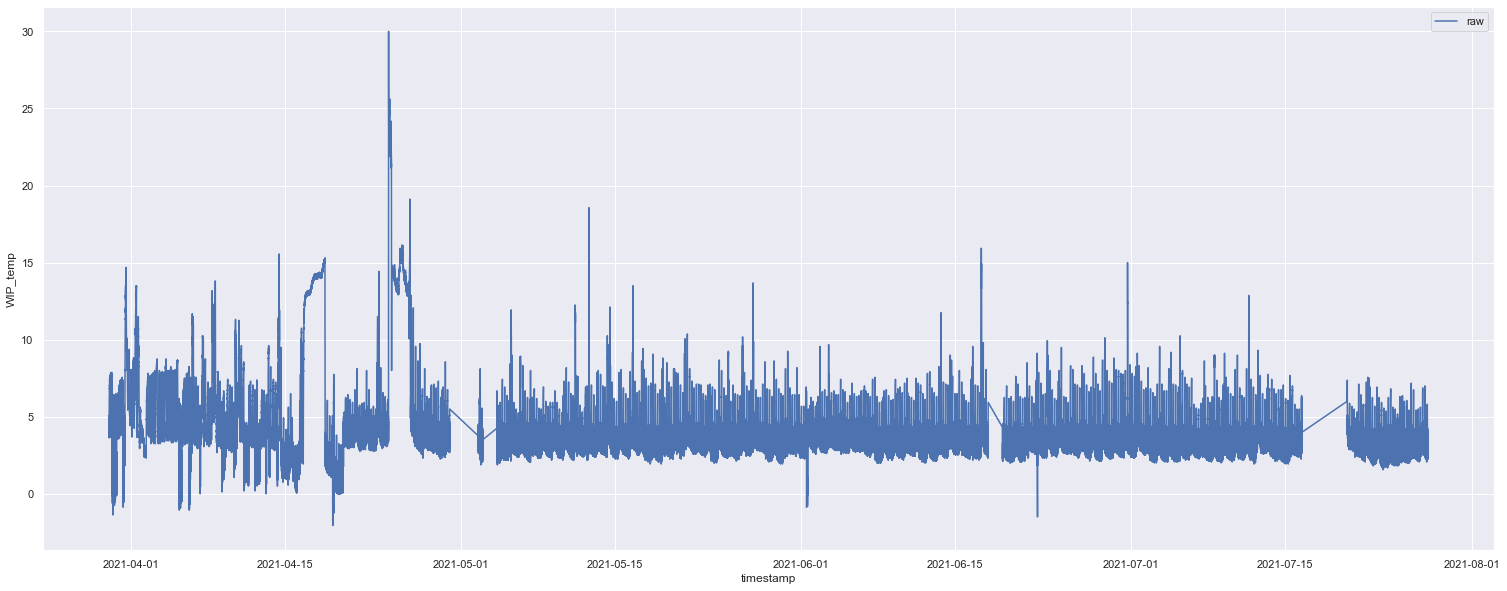

In [19]:
# lineplot of raw data
sns.lineplot(x=dfp.index, y="WIP_temp", data=dfp, label="raw");

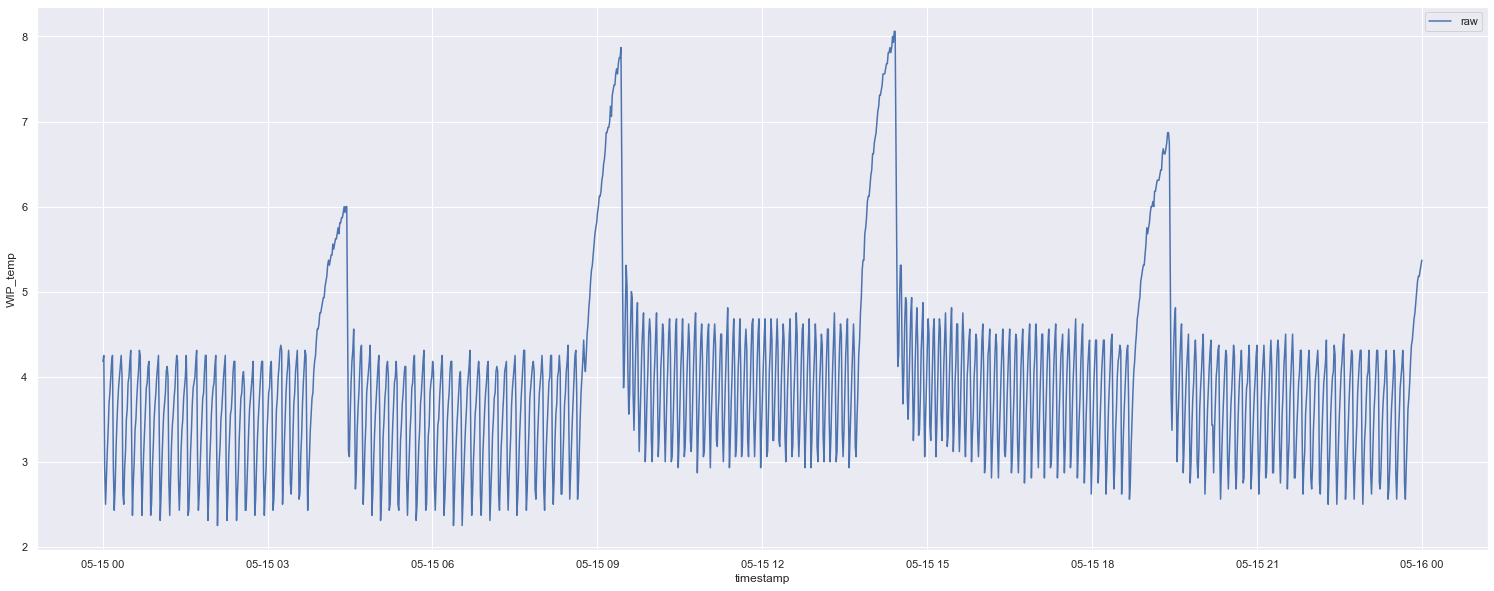

In [21]:
# select a period of "normal data" to use as comparison
filter_raw = (dfp.index > '2021-05-15') & (dfp.index < '2021-05-16')
sns.lineplot(x=dfp.index[filter_raw], y="WIP_temp", data=dfp[filter_raw], label="raw");

These are typical cycle trends for this system. The large peaks are the periodic defrost cycles while the trends in between is the normal refridgeration cycle swithcing on and off periodically. Current alert limits are between 0 and 8.5 and alarms limits -2 and 10 degrees Celcius.

In [22]:
# resample in 1 minute intervals
dfp_1min = dfp.resample("1min").mean()
dfp_1min[100:110].head(10)

sensor_id_id,WIP_temp,DP_temp,Ext_temp,WIP_current,DP_current
timestamp,,,,,
2021-03-30 01:40:00,7.4975,3.167500,16.185000,8.290000,2.7600
2021-03-30 01:41:00,7.5200,2.623333,16.726667,8.220000,2.7250
2021-03-30 01:42:00,7.5000,2.310000,16.995000,5.020000,2.7250
2021-03-30 01:43:00,7.5600,2.745000,17.025000,1.820000,2.7600
2021-03-30 01:44:00,7.5450,3.310000,16.747500,3.420000,2.7425
2021-03-30 01:45:00,7.5600,3.413333,16.536667,8.336667,2.7600
2021-03-30 01:46:00,7.5600,2.830000,16.580000,8.406667,2.7600
2021-03-30 01:47:00,7.5300,2.400000,16.465000,8.430000,2.7600
2021-03-30 01:48:00,7.5800,2.600000,16.203333,1.820000,2.7600


In [23]:
# resample in 5 minute intervals
dfp_5min = dfp.resample("5min").mean()
dfp_5min[100:110].head(10)

sensor_id_id,WIP_temp,DP_temp,Ext_temp,WIP_current,DP_current
timestamp,,,,,
2021-03-30 08:20:00,-0.465294,3.395882,16.558235,11.070000,5.221176
2021-03-30 08:25:00,1.819444,2.926667,17.415556,6.830588,7.783529
2021-03-30 08:30:00,1.495294,2.708824,17.055294,19.161111,7.710000
2021-03-30 08:35:00,-0.137222,3.590000,17.477778,21.532222,2.010000
2021-03-30 08:40:00,0.323333,5.347778,16.716111,12.840588,1.675882
2021-03-30 08:45:00,2.065294,7.691176,17.145882,15.828333,1.672222
2021-03-30 08:50:00,1.013333,7.850000,16.549444,21.524706,1.634706
2021-03-30 08:55:00,-0.347059,8.590588,16.912353,16.366111,1.610000
2021-03-30 09:00:00,1.403529,8.864118,16.955882,6.772941,1.610000


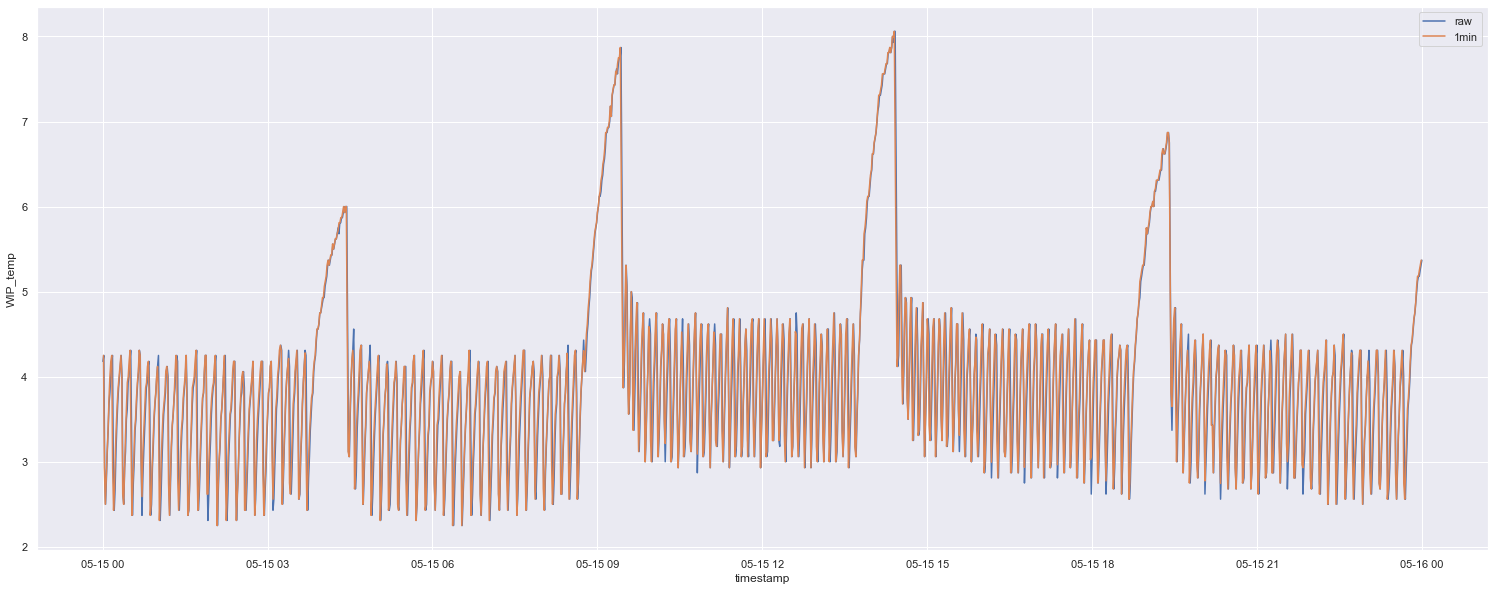

In [26]:
# compare raw data and 1 minute resampled data for WIP cold room temperature
sns.lineplot(x=dfp.index[filter_raw], y="WIP_temp", data=dfp[filter_raw], label="raw")

filter_1min = (dfp_1min.index > '2021-05-15') & (dfp_1min.index < '2021-05-16')
sns.lineplot(x=dfp_1min.index[filter_1min], y="WIP_temp", data=dfp_1min[filter_1min], label="1min");

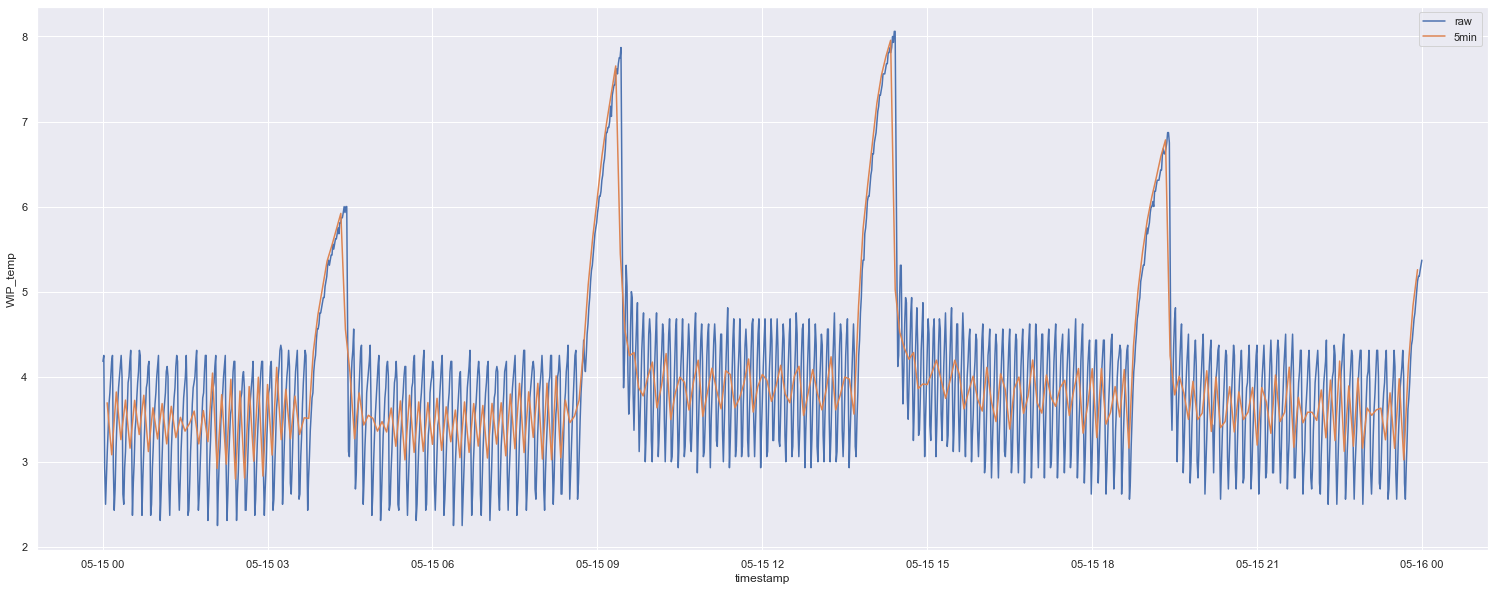

In [27]:
# compare raw data and 5 minute resampled data
sns.lineplot(x=dfp.index[filter_raw], y="WIP_temp", data=dfp[filter_raw], label="raw")

filter_5min = (dfp_5min.index > '2021-05-15') & (dfp_5min.index < '2021-05-16')
sns.lineplot(x=dfp_5min.index[filter_5min], y="WIP_temp", data=dfp_5min[filter_5min], label="5min");

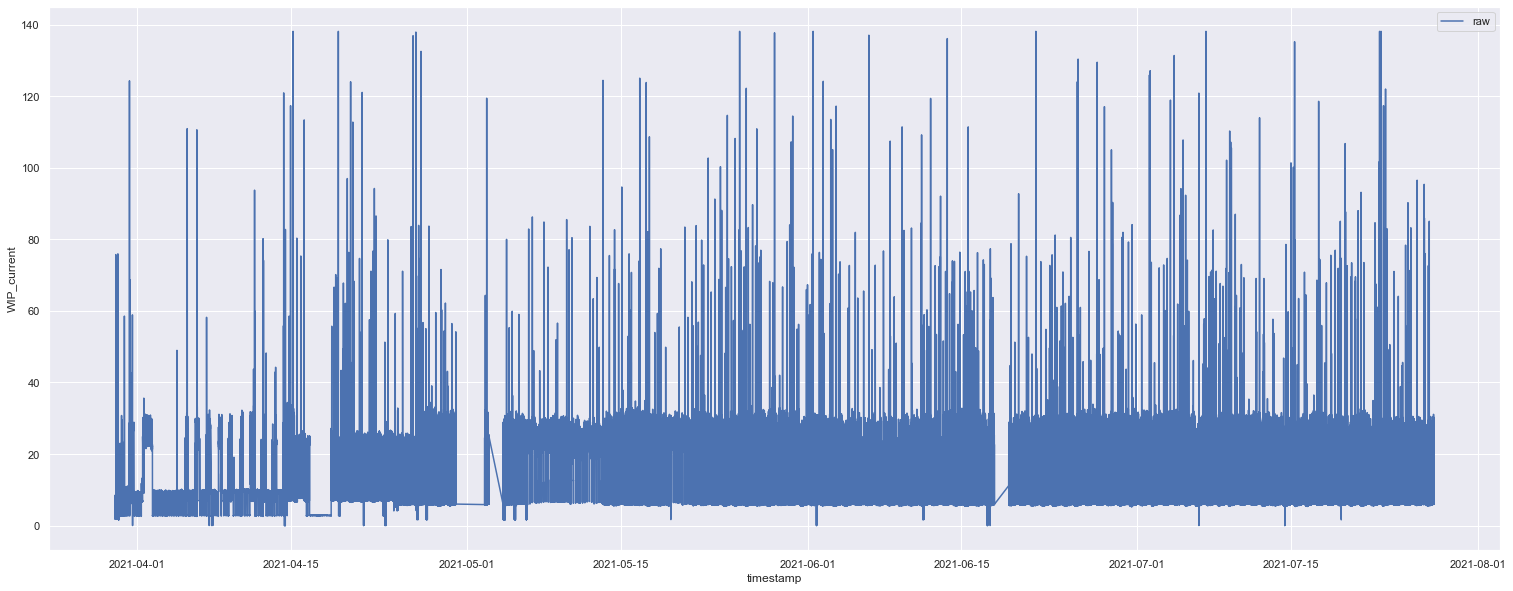

In [28]:
# raw data for current of the WIP refridgeration system
sns.lineplot(x=dfp.index, y="WIP_current", data=dfp, label="raw");

Data looks very noisy as expected as energy consumption depends on several factors and varies a lot based on the loads connected.

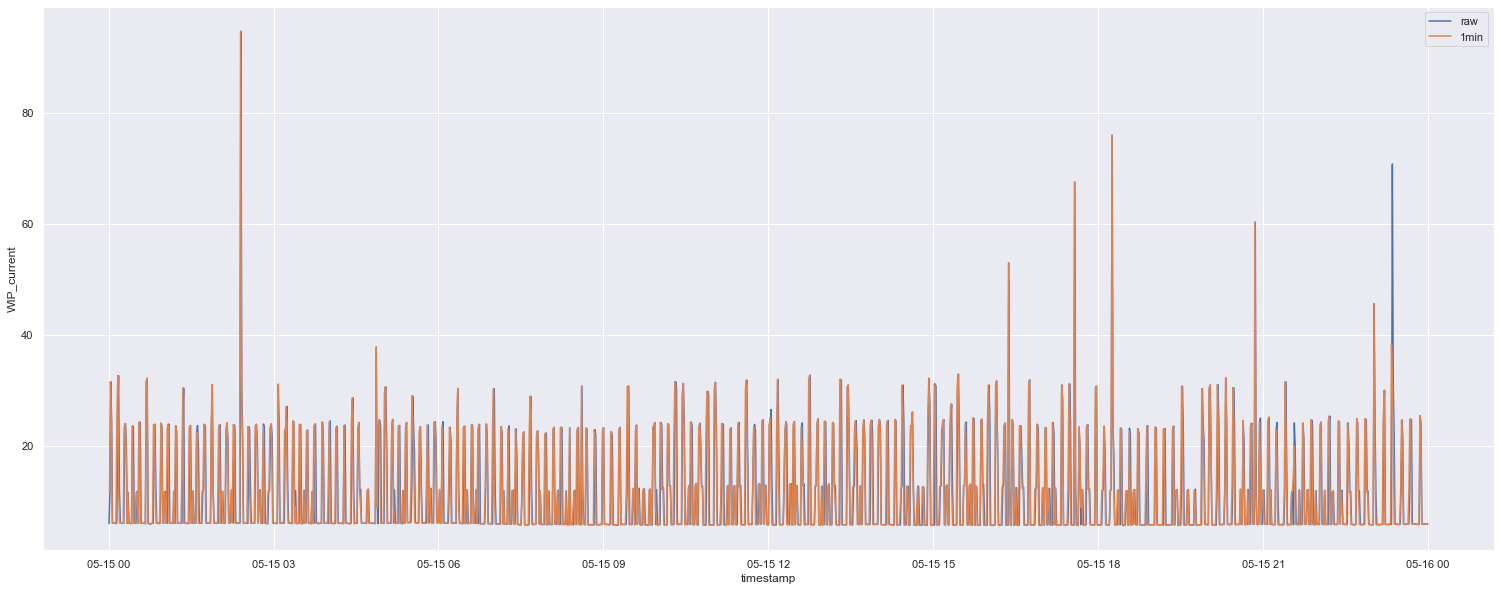

In [29]:
# compare raw data and 1 minute resampled data for WIP cold room temperature
sns.lineplot(x=dfp.index[filter_raw], y="WIP_current", data=dfp[filter_raw], label="raw")

filter_1min = (dfp_1min.index > '2021-05-15') & (dfp_1min.index < '2021-05-16')
sns.lineplot(x=dfp_1min.index[filter_1min], y="WIP_current", data=dfp_1min[filter_1min], label="1min");

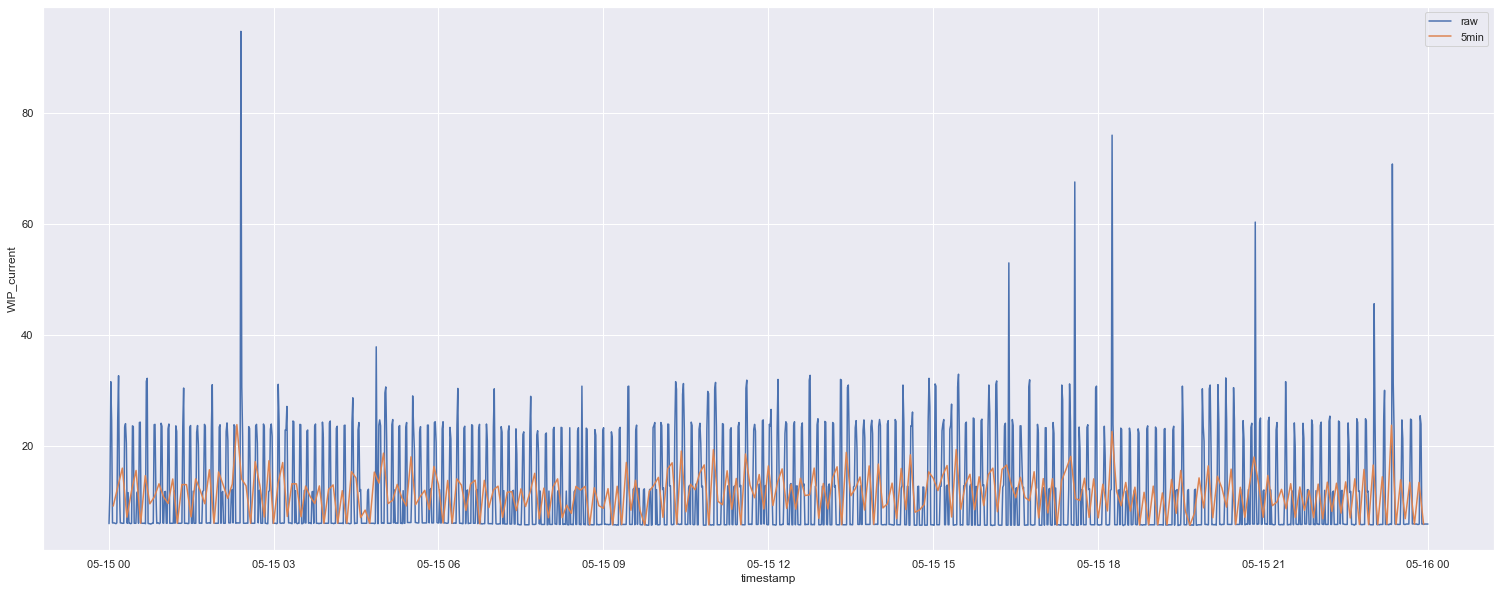

In [30]:
# compare raw data and 5 minute resampled data
sns.lineplot(x=dfp.index[filter_raw], y="WIP_current", data=dfp[filter_raw], label="raw")

filter_5min = (dfp_5min.index > '2021-05-15') & (dfp_5min.index < '2021-05-16')
sns.lineplot(x=dfp_5min.index[filter_5min], y="WIP_current", data=dfp_5min[filter_5min], label="5min");

By using 1 minute average data, we keep most of the variability in the data and gives the best real-time view. By using a 5 minute average, the variation in the normal on-off cycle is slightly reduced but the defrost spike is still prominent.

For anomaly detection, the 5 minute data would provide enough information to monitor the refridgeration system and take into account the defrost cycle. As quick action (that is within a seconds) is not needed, this should be good.

For the energy analysis, the 1 minute data would be used to calculate the sum of energy used per hour. The mean would be calculated for temperatures and sum of the current values would give an energy value in Ah. The voltage at the site is 400V in a three-phase system. An average power factor of 0.85 would be assumed.

In [31]:
# calculate Amps-Hours
dfp_1min['WIP_currentAh'] = dfp_1min.WIP_current/60
dfp_1min['DP_currentAh'] = dfp_1min.DP_current/60

In [32]:
dfp_1min.columns

Index(['WIP_temp', 'DP_temp', 'Ext_temp', 'WIP_current', 'DP_current',
       'WIP_currentAh', 'DP_currentAh'],
      dtype='object', name='sensor_id_id')

In [33]:
# resample data - mean for temperatures and sum for energy values (Ah)
dfp_hour = dfp_1min.resample("60min").agg({"WIP_temp": "mean", "DP_temp": "mean", "Ext_temp": "mean", "WIP_currentAh": "sum", "DP_currentAh": "sum"})
dfp_hour.head()

sensor_id_id,WIP_temp,DP_temp,Ext_temp,WIP_currentAh,DP_currentAh
timestamp,,,,,
2021-03-30 00:00:00,5.073109,2.975897,17.275080,4.867222,5.336014
2021-03-30 01:00:00,7.224663,2.952083,16.797564,5.713958,2.960903
2021-03-30 02:00:00,5.174319,4.074458,15.969708,4.247333,6.237069
2021-03-30 03:00:00,7.380833,5.051847,16.267139,5.159278,2.948403
2021-03-30 04:00:00,5.196708,2.939181,16.383194,5.470403,6.847056


In [34]:
# convert Ah to kWh using voltage and assumed power factor
dfp_hour["WIP_energy"] = math.sqrt(3) * 400 * dfp_hour["WIP_currentAh"] * 0.85 / 1000
dfp_hour["DP_energy"] = math.sqrt(3) * 400 * dfp_hour["DP_currentAh"] * 0.85 / 1000

In [35]:
dfp_hour.head()

sensor_id_id,WIP_temp,DP_temp,Ext_temp,WIP_currentAh,DP_currentAh,WIP_energy,DP_energy
timestamp,,,,,,,
2021-03-30 00:00:00,5.073109,2.975897,17.275080,4.867222,5.336014,2.866294,3.142364
2021-03-30 01:00:00,7.224663,2.952083,16.797564,5.713958,2.960903,3.364934,1.743668
2021-03-30 02:00:00,5.174319,4.074458,15.969708,4.247333,6.237069,2.501243,3.672993
2021-03-30 03:00:00,7.380833,5.051847,16.267139,5.159278,2.948403,3.038285,1.736306
2021-03-30 04:00:00,5.196708,2.939181,16.383194,5.470403,6.847056,3.221505,4.032212


In [36]:
# save data to SQLite DB
engine = create_engine(f"sqlite:///../data/RawData.db")
dfp.to_sql("SensorData_raw", engine, if_exists="replace")

In [37]:
dfp_1min.to_sql("SensorData_1min", engine, if_exists="replace")

In [38]:
dfp_5min.to_sql("SensorData_5min", engine, if_exists="replace")

In [39]:
dfp_hour.to_sql("SensorData_1hour", engine, if_exists="replace")

In [40]:
df_meta.to_sql("SensorDetails", engine, if_exists="replace")